# Import library

In [1]:
# Core data manipulation libraries
import pandas as pd
import numpy as np
from typing import List, Tuple, Dict, Optional
import warnings
warnings.filterwarnings('ignore')

# Chemistry and molecular manipulation
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, Draw
from rdkit.Chem import rdMolDescriptors

# Machine learning - scikit-learn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score,
    average_precision_score,  # For AUPRC
    f1_score,
    precision_recall_curve,
    roc_curve,
    auc
)
from sklearn.model_selection import GridSearchCV, PredefinedSplit


# Deep learning - PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

from transformers import AutoTokenizer, AutoModel

# Explainable AI
import shap

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Utilitiesimport os
import os
import pickle
import json
from datetime import datetime
from tqdm import tqdm
import random
import joblib



The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.
0it [00:00, ?it/s]


In [2]:
# Set random seeds for reproducibility
def set_seed(seed: int = 42):
    """
    Set random seeds for reproducibility across all libraries.
    
    Args:
        seed: Random seed value (default: 42)
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = set_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Data preprosessing

In [3]:
# Path to your dataset
DATA_PATH = "dataset/bioactivity_data.csv"

In [4]:
df = pd.read_csv(DATA_PATH,delimiter=';')
df.head()

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties,Action Type,Standard Text Value,Value
0,CHEMBL6034481,NaN,NaN,574.71,2.0,5.70,BDBM517794,C=CC(=O)Nc1cc(Nc2ncc(C)c(-c3cc(F)c4nc(C)n(C(C)...,IC50,'=',...,CHEMBL5728717,37,BindingDB Patent Bioactivity Data,NaN,2021.0,NaN,NaN,NaN,NaN,25.0
1,CHEMBL5962799,NaN,NaN,563.70,2.0,6.05,BDBM517803,C=CC(=O)Nc1cc(Nc2nccc(-c3cc(F)c4nc(C)n(C(C)C)c...,IC50,'<',...,CHEMBL5728717,37,BindingDB Patent Bioactivity Data,NaN,2021.0,NaN,NaN,NaN,NaN,1.0
2,CHEMBL6061951,NaN,NaN,545.62,2.0,5.24,BDBM517808,C=CC(=O)Nc1cc(Nc2nccc(-c3cc(F)c4nc(C)n(C(C)C)c...,IC50,'=',...,CHEMBL5728717,37,BindingDB Patent Bioactivity Data,NaN,2021.0,NaN,NaN,NaN,NaN,25.0
3,CHEMBL1254199,NaN,NaN,408.30,0.0,4.66,4,CN(c1cccc(Br)c1)c1nc(N)nc2[nH]c(Cc3ccccc3)cc12,IC50,'=',...,CHEMBL1250424,1,Scientific Literature,Bioorg Med Chem,2010.0,CHEMBL3307523,NaN,NaN,NaN,53.1
4,CHEMBL1254286,NaN,NaN,422.33,0.0,4.67,6,CN(c1cccc(Br)c1)c1nc(N)nc2c1cc(Cc1ccccc1)n2C,IC50,'=',...,CHEMBL1250424,1,Scientific Literature,Bioorg Med Chem,2010.0,CHEMBL3307523,NaN,NaN,NaN,253.6


In [5]:
df.shape

(25758, 48)

In [6]:
df.columns.tolist()

['Molecule ChEMBL ID',
 'Molecule Name',
 'Molecule Max Phase',
 'Molecular Weight',
 '#RO5 Violations',
 'AlogP',
 'Compound Key',
 'Smiles',
 'Standard Type',
 'Standard Relation',
 'Standard Value',
 'Standard Units',
 'pChEMBL Value',
 'Data Validity Comment',
 'Comment',
 'Uo Units',
 'Ligand Efficiency BEI',
 'Ligand Efficiency LE',
 'Ligand Efficiency LLE',
 'Ligand Efficiency SEI',
 'Potential Duplicate',
 'Assay ChEMBL ID',
 'Assay Description',
 'Assay Type',
 'BAO Format ID',
 'BAO Label',
 'Assay Organism',
 'Assay Tissue ChEMBL ID',
 'Assay Tissue Name',
 'Assay Cell Type',
 'Assay Subcellular Fraction',
 'Assay Parameters',
 'Assay Variant Accession',
 'Assay Variant Mutation',
 'Target ChEMBL ID',
 'Target Name',
 'Target Organism',
 'Target Type',
 'Document ChEMBL ID',
 'Source ID',
 'Source Description',
 'Document Journal',
 'Document Year',
 'Cell ChEMBL ID',
 'Properties',
 'Action Type',
 'Standard Text Value',
 'Value']

In [7]:
cols_to_keep = [
    'Molecule ChEMBL ID',  
    'Smiles',              
    'Standard Value',      
    'Standard Units',      
    'Standard Relation'    
]

In [8]:
existing_cols = [c for c in cols_to_keep if c in df.columns]
df = df[existing_cols]

In [9]:
print(f"Shape after dropping columns: {df.shape}")
print(f"Columns kept: {list(df.columns)}")

Shape after dropping columns: (25758, 5)
Columns kept: ['Molecule ChEMBL ID', 'Smiles', 'Standard Value', 'Standard Units', 'Standard Relation']


In [10]:
df.describe()

,Standard Value
count,2.436300e+04
mean,3.103449e+06
std,4.841510e+07
min,5.012000e-09
25%,1.300000e+01
50%,1.000000e+02
75%,1.751500e+03
max,9.332543e+08


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25758 entries, 0 to 25757
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Molecule ChEMBL ID  25758 non-null  object 
 1   Smiles              25711 non-null  object 
 2   Standard Value      24363 non-null  float64
 3   Standard Units      24505 non-null  object 
 4   Standard Relation   24366 non-null  object 
dtypes: float64(1), object(4)
memory usage: 1006.3+ KB


In [12]:
df.isnull().sum()

Molecule ChEMBL ID       0
Smiles                  47
Standard Value        1395
Standard Units        1253
Standard Relation     1392
dtype: int64

In [13]:
df["Standard Units"].unique()

array(['nM', nan, 'ug.mL-1', '/uM', '10^-5 mol/L', '10^3 uM'],
      dtype=object)

In [14]:
df["Standard Relation"].unique()

array(["'='", "'<'", "'>'", nan, "'<='", "'>>'", "'~'", "'>='"],
      dtype=object)

In [15]:
df = df.dropna(subset=['Smiles', 'Standard Value', 'Standard Units'])

In [16]:
df["Standard Units"].unique()

array(['nM', 'ug.mL-1', '/uM', '10^-5 mol/L', '10^3 uM'], dtype=object)

In [17]:
df = df[df['Standard Units'] == 'nM']
if 'Standard Relation' in df.columns:
    df = df[df['Standard Relation'] == "'='"]

In [18]:
df.isnull().sum()

Molecule ChEMBL ID    0
Smiles                0
Standard Value        0
Standard Units        0
Standard Relation     0
dtype: int64

In [19]:
# Handle negative or zero values (mathematically impossible for concentration)
# Clip to a tiny positive number to prevent log errors
df['Standard Value'] = df['Standard Value'].clip(lower=1e-9)

In [20]:
# Standardize chemical structures using RDKit
def canonicalize_smiles(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return Chem.MolToSmiles(mol, canonical=True) # Returns unique string for molecule
        else:
            return None
    except:
        return None

In [21]:
df['Canonical_Smiles'] = df['Smiles'].apply(canonicalize_smiles)
df = df.dropna(subset=['Canonical_Smiles'])

In [22]:
# Remove duplicate molecules (keep the one with median value or just drop duplicates)
df = df.drop_duplicates(subset=['Canonical_Smiles'])

## Labeling

In [23]:
# pIC50 = -log10(Value * 10^-9)
df['pIC50'] = -np.log10(df['Standard Value'] * 10**-9)

In [24]:
#Active if pIC50 >= 6.0 (Equivalent to IC50 <= 1000 nM / 1uM)
df['active'] = (df['pIC50'] >= 6.0).astype(int)

In [25]:
print(f"Cleaned Data Shape: {df.shape}")
print("\nClass Distribution:")
print(df['active'].value_counts())

Cleaned Data Shape: (10566, 8)

Class Distribution:
active
1    7727
0    2839
Name: count, dtype: int64


In [26]:
print(df[['Standard Value', 'pIC50', 'active']].head())

   Standard Value     pIC50  active
0            25.0  7.602060       1
2            25.0  7.602060       1
3         53100.0  4.274905       0
4        253600.0  3.595851       0
5          6200.0  5.207608       0


In [27]:
df = df[['Molecule ChEMBL ID', 'Canonical_Smiles', 'pIC50', 'active']].reset_index(drop=True)

In [28]:
df.head()

,Molecule ChEMBL ID,Canonical_Smiles,pIC50,active
0,CHEMBL6034481,C=CC(=O)Nc1cc(Nc2ncc(C)c(-c3cc(F)c4nc(C)n(C(C)...,7.602060,1
1,CHEMBL6061951,C=CC(=O)Nc1cc(Nc2nccc(-c3cc(F)c4nc(C)n(C(C)C)c...,7.602060,1
2,CHEMBL1254199,CN(c1cccc(Br)c1)c1nc(N)nc2[nH]c(Cc3ccccc3)cc12,4.274905,0
3,CHEMBL1254286,CN(c1cccc(Br)c1)c1nc(N)nc2c1cc(Cc1ccccc1)n2C,3.595851,0
4,CHEMBL5900674,C=CC(=O)Nc1cccc(Nc2nc(Nc3ccc(N4CC5CCC(C4)N5C(C...,5.207608,0


# Data Spliting

In [29]:
X_data = df['Canonical_Smiles'].values
y_data = df['active'].values

In [30]:
X_train_raw, X_temp, y_train, y_temp = train_test_split(X_data, y_data, test_size=0.3, stratify=y_data, random_state=seed)

In [31]:
X_val_raw, X_test_raw, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=seed)

In [32]:
print(f"Train Set: {len(X_train_raw)}")
print(f"Val Set:   {len(X_val_raw)}")
print(f"Test Set:  {len(X_test_raw)}")

Train Set: 7396
Val Set:   1585
Test Set:  1585


# Baseline model


## Fingerprints


In [33]:
def generate_fingerprints(smiles_list):
    fps = []
    for s in smiles_list:
        mol = Chem.MolFromSmiles(s)
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024)
        fps.append(np.array(fp))
    return np.array(fps)


In [34]:
X_train_fp = generate_fingerprints(X_train_raw)
X_val_fp = generate_fingerprints(X_val_raw)
X_test_fp = generate_fingerprints(X_test_raw)



[16:33:23] DEPRECATION WARNING: please use MorganGenerator
[16:33:23] DEPRECATION WARNING: please use MorganGenerator
[16:33:23] DEPRECATION WARNING: please use MorganGenerator
[16:33:23] DEPRECATION WARNING: please use MorganGenerator
[16:33:23] DEPRECATION WARNING: please use MorganGenerator
[16:33:23] DEPRECATION WARNING: please use MorganGenerator
[16:33:23] DEPRECATION WARNING: please use MorganGenerator
[16:33:23] DEPRECATION WARNING: please use MorganGenerator
[16:33:23] DEPRECATION WARNING: please use MorganGenerator
[16:33:23] DEPRECATION WARNING: please use MorganGenerator
[16:33:23] DEPRECATION WARNING: please use MorganGenerator
[16:33:23] DEPRECATION WARNING: please use MorganGenerator
[16:33:23] DEPRECATION WARNING: please use MorganGenerator
[16:33:23] DEPRECATION WARNING: please use MorganGenerator
[16:33:23] DEPRECATION WARNING: please use MorganGenerator
[16:33:23] DEPRECATION WARNING: please use MorganGenerator
[16:33:23] DEPRECATION WARNING: please use MorganGenerat

In [35]:
# avoid data and utilizes the correct fixed set of Val
X_train_val_fp = np.vstack((X_train_fp, X_val_fp))
y_train_val = np.concatenate((y_train, y_val))



In [36]:
#-1 is train, 0 is val
split_index = [-1]*len(X_train_fp) + [0]*len(X_val_fp)
pds = PredefinedSplit(test_fold=split_index)


## LOGISTIC REGRESSION


In [37]:
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],   # Regularization strength
    'penalty': ['l2'],         # Ridge regression
    'solver': ['lbfgs']
}


In [38]:
grid_lr = GridSearchCV(LogisticRegression(max_iter=1000, class_weight='balanced', random_state=seed),
                       param_grid_lr, cv=pds, scoring='f1', n_jobs=-1, verbose=1)

grid_lr.fit(X_train_val_fp, y_train_val)


Fitting 1 folds for each of 4 candidates, totalling 4 fits


,estimator,LogisticRegre...max_iter=1000)
,param_grid,"{'C': [0.01, 0.1, ...], 'penalty': ['l2'], 'solver': ['lbfgs']}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,"PredefinedSpl......, 0, 0]))"
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [39]:
best_lr = grid_lr.best_estimator_
print(f"Best LR Params: {grid_lr.best_params_}")


Best LR Params: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}


In [40]:
# Evaluate LR
y_prob_lr = best_lr.predict_proba(X_test_fp)[:, 1]
y_pred_lr = best_lr.predict(X_test_fp)
auprc_lr = average_precision_score(y_test, y_prob_lr)
f1_lr = f1_score(y_test, y_pred_lr)
print(f"Logistic Regression: AUPRC={auprc_lr:.4f} | F1={f1_lr:.4f}")


Logistic Regression: AUPRC=0.9481 | F1=0.8786


## RANDOM FOREST


In [41]:
param_grid_rf = {
    'n_estimators': [100, 200],      
    'max_depth': [None, 10, 20],     
    'min_samples_leaf': [1, 2]       
}
grid_rf = GridSearchCV(RandomForestClassifier(class_weight='balanced', random_state=seed),
                       param_grid_rf, cv=pds, scoring='f1', n_jobs=-1, verbose=1)



In [42]:
grid_rf.fit(X_train_val_fp, y_train_val)
best_rf = grid_rf.best_estimator_
print(f"Best RF Params: {grid_rf.best_params_}")


Fitting 1 folds for each of 12 candidates, totalling 12 fits
Best RF Params: {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 200}


In [43]:
# Evaluate RF
y_prob_rf = best_rf.predict_proba(X_test_fp)[:, 1]
y_pred_rf = best_rf.predict(X_test_fp)
auprc_rf = average_precision_score(y_test, y_prob_rf)
f1_rf = f1_score(y_test, y_pred_rf)
print(f"Random Forest: AUPRC={auprc_rf:.4f} | F1={f1_rf:.4f}")


Random Forest: AUPRC=0.9681 | F1=0.9189


## BASIC 1-LAYER CNN


In [44]:
all_chars = sorted(list(set("".join(df['Canonical_Smiles'].values))))
char_map = {c: i+1 for i, c in enumerate(all_chars)}
vocab_sz = len(all_chars) + 1



In [45]:
def fast_tokenize(smiles):
    seq = [char_map[c] for c in smiles]
    return seq + [0]*(100-len(seq)) if len(seq)<100 else seq[:100]


In [46]:
X_train_seq_base = torch.tensor([fast_tokenize(s) for s in X_train_raw], dtype=torch.long).to(device)
y_train_seq_base = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)
X_test_seq_base = torch.tensor([fast_tokenize(s) for s in X_test_raw], dtype=torch.long).to(device)


In [47]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.emb = nn.Embedding(vocab_sz, 64, padding_idx=0)
        self.conv = nn.Conv1d(64, 32, kernel_size=3) # 1 Layer CNN duy nhất
        self.pool = nn.AdaptiveMaxPool1d(1)          # Global Max Pooling
        self.fc = nn.Linear(32, 1)                   # Output
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.emb(x).permute(0, 2, 1) # [Batch, Embed, Seq]
        x = self.pool(self.conv(x)).squeeze(2)
        return self.sigmoid(self.fc(x))


In [48]:
base_cnn = SimpleCNN().to(device)
opt_base = Adam(base_cnn.parameters(), lr=0.001)
crit_base = nn.BCELoss()


In [49]:
base_cnn.train()
for ep in range(20):
    opt_base.zero_grad()
    out = base_cnn(X_train_seq_base)
    loss = crit_base(out, y_train_seq_base)
    loss.backward()
    opt_base.step()


In [50]:
# Evaluate CNN
base_cnn.eval()
with torch.no_grad():
    y_prob_cnn = base_cnn(X_test_seq_base).cpu().numpy().flatten()
y_pred_cnn = (y_prob_cnn >= 0.5).astype(int)

auprc_cnn = average_precision_score(y_test, y_prob_cnn)
f1_cnn = f1_score(y_test, y_pred_cnn)
print(f"Simple CNN: AUPRC={auprc_cnn:.4f} | F1={f1_cnn:.4f}")


Simple CNN: AUPRC=0.9018 | F1=0.8639


## Summarize

In [51]:
baseline_results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'Simple CNN'],
    'AUPRC': [auprc_lr, auprc_rf, auprc_cnn],
    'F1-Score': [f1_lr, f1_rf, f1_cnn]
})
print("\nBASELINE METRICS SUMMARY")
display(baseline_results)



BASELINE METRICS SUMMARY


,Model,AUPRC,F1-Score
0,Logistic Regression,0.948090,0.878639
1,Random Forest,0.968133,0.918850
2,Simple CNN,0.901806,0.863928


In [52]:
model_dir = 'models'

joblib.dump(best_rf, f'{model_dir}/best_baseline_rf.joblib')
print("Best Baseline Model (Random Forest) Saved at " + model_dir)



Best Baseline Model (Random Forest) Saved at models


In [53]:
models_data = [
    ('Logistic Regression', y_pred_lr, y_prob_lr, 'blue'),
    ('Random Forest', y_pred_rf, y_prob_rf, 'green'),
    ('Simple CNN', y_pred_cnn, y_prob_cnn, 'red')
]

sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams.update({'font.size': 12, 'axes.titleweight': 'bold'})


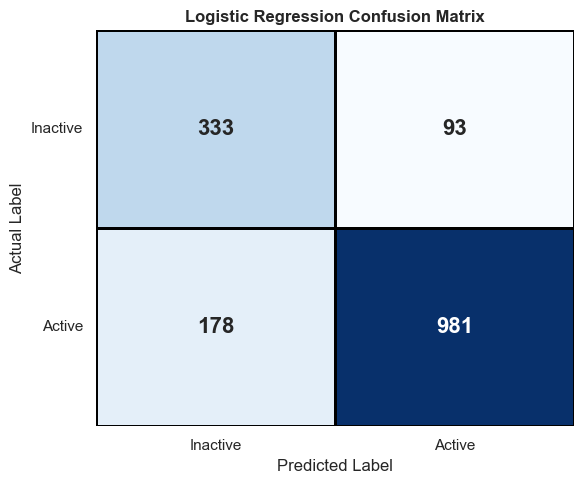

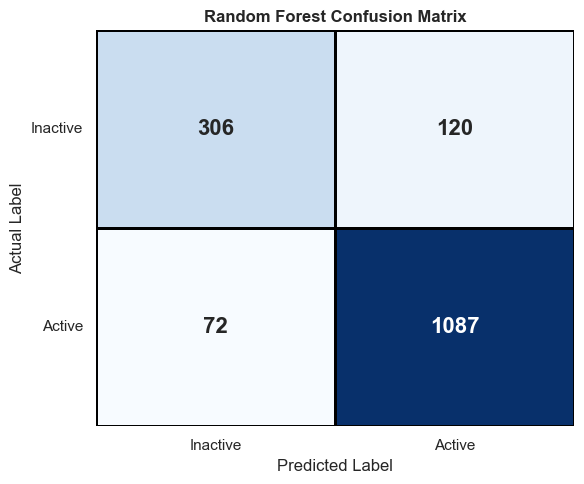

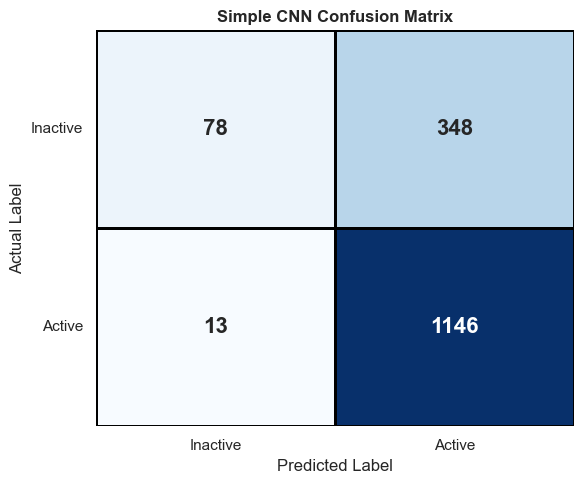

In [54]:
for name, pred, _, _ in models_data:
    plt.figure(figsize=(6, 5)) # Kích thước chuẩn cho 1 hình vuông vắn
    cm = confusion_matrix(y_test, pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                annot_kws={"size": 16, "weight": "bold"},
                linewidths=1, linecolor='black')
    
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.xticks([0.5, 1.5], ['Inactive', 'Active'])
    plt.yticks([0.5, 1.5], ['Inactive', 'Active'], rotation=0)
    plt.tight_layout()
    plt.show() 

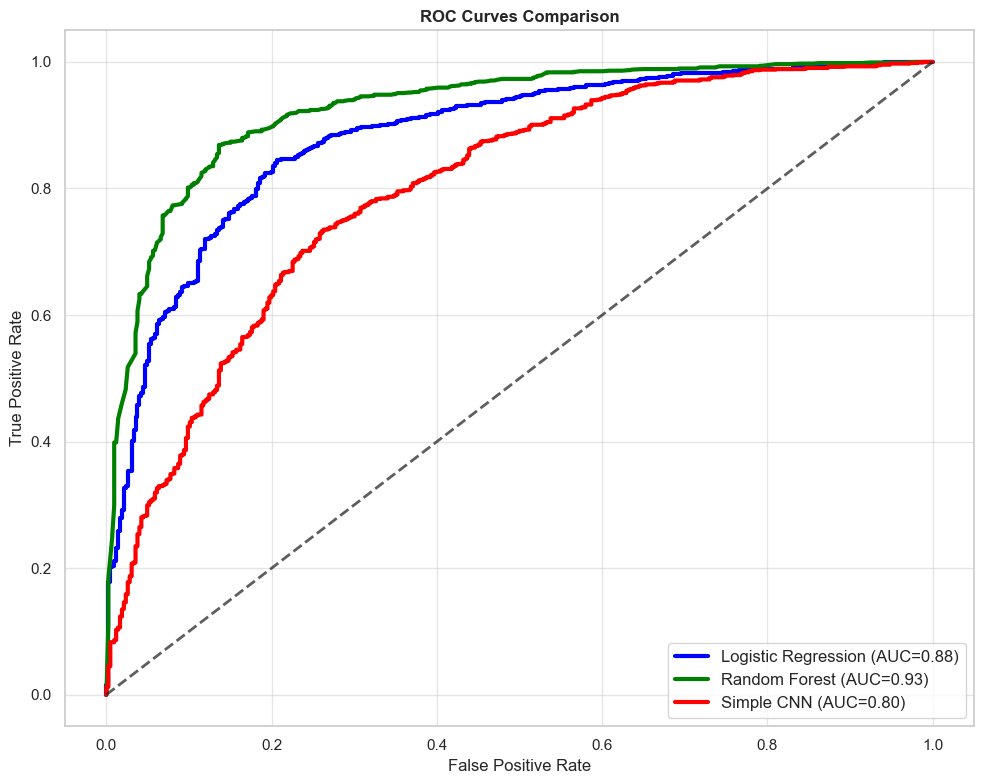

In [55]:

# ROC Curves
plt.figure(figsize=(10, 8)) # Hình chữ nhật lớn

for name, _, prob, color in models_data:
    fpr, tpr, _ = roc_curve(y_test, prob)
    plt.plot(fpr, tpr, color=color, lw=3, label=f"{name} (AUC={auc(fpr,tpr):.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.7)
plt.title("ROC Curves Comparison")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

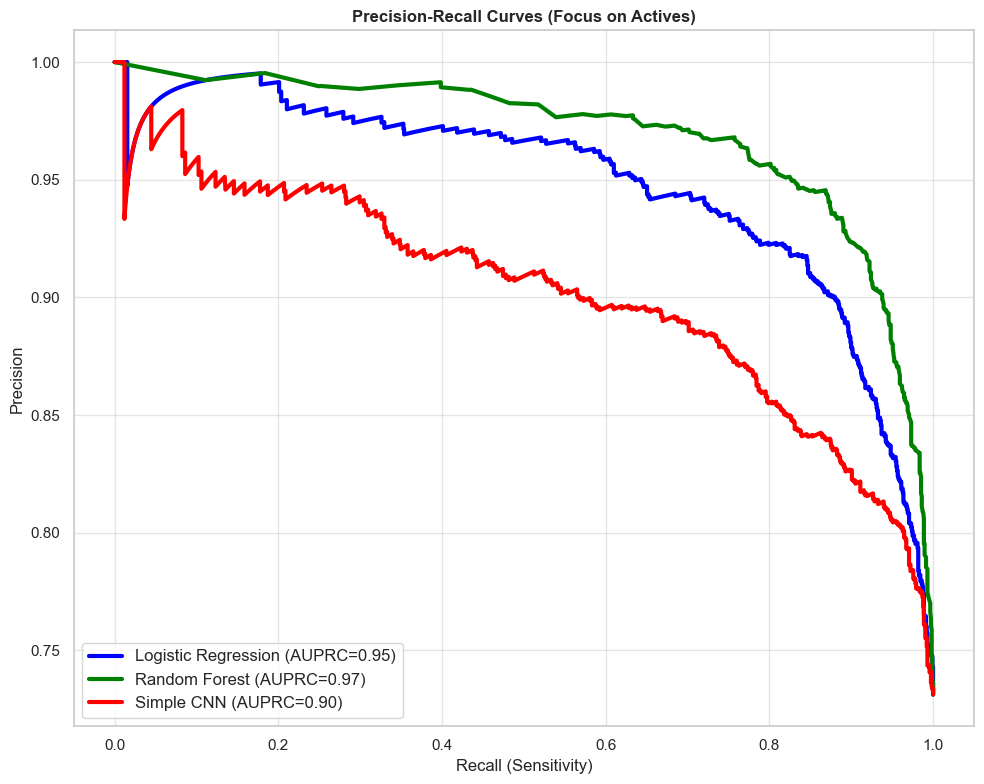

In [56]:
# Precision-Recall Curves Comparison
plt.figure(figsize=(10, 8))

for name, _, prob, color in models_data:
    p, r, _ = precision_recall_curve(y_test, prob)
    ap = average_precision_score(y_test, prob)
    plt.plot(r, p, color=color, lw=3, label=f"{name} (AUPRC={ap:.2f})")

plt.title("Precision-Recall Curves (Focus on Actives)")
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision')
plt.legend(loc="lower left", fontsize=12)
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

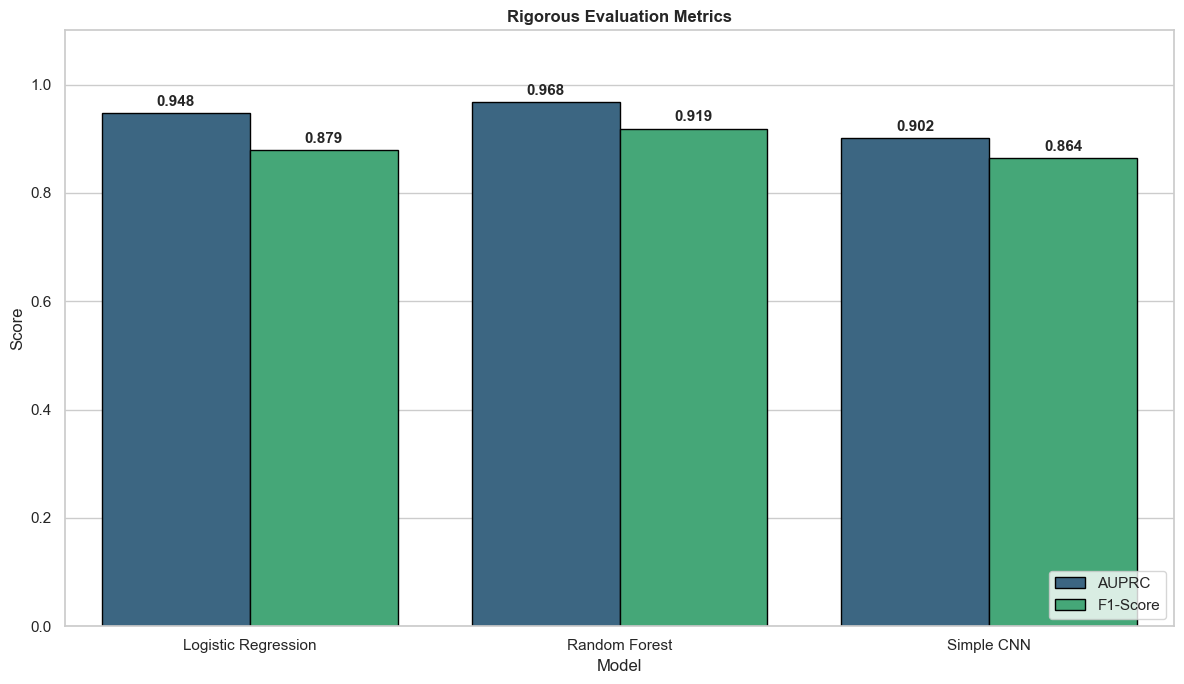

In [57]:
# Metrics Comparison (AUPRC vs F1)
plt.figure(figsize=(12, 7))

df_melted = baseline_results.melt(id_vars="Model", var_name="Metric", value_name="Score")
ax = sns.barplot(data=df_melted, x='Model', y='Score', hue='Metric', 
                 palette='viridis', edgecolor='black')

plt.title("Rigorous Evaluation Metrics")
plt.ylim(0, 1.1)
plt.legend(loc='lower right')

# Thêm số lên đầu cột
for p in ax.patches:
    if p.get_height() > 0:
        ax.annotate(f'{p.get_height():.3f}', 
                    (p.get_x() + p.get_width()/2., p.get_height()), 
                    ha='center', va='bottom', fontsize=11, weight='bold', xytext=(0, 3), 
                    textcoords='offset points')
plt.tight_layout()
plt.show()

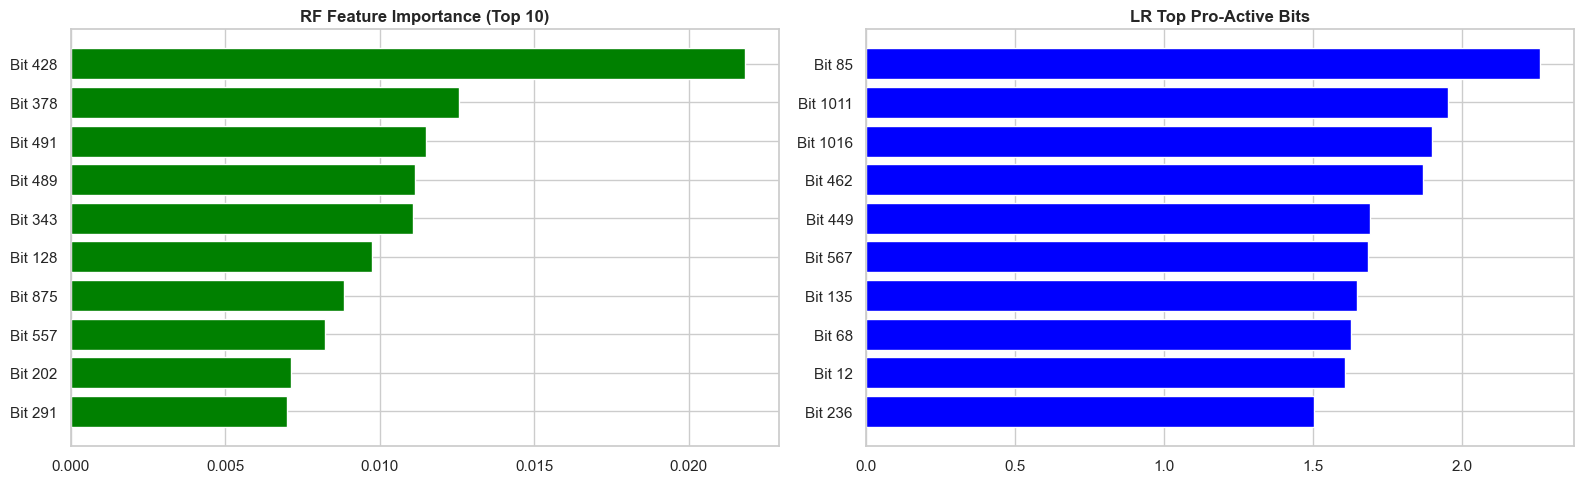

In [58]:
#Model Interpretability
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Random Forest Feature Importance
imps = best_rf.feature_importances_
top_idx = np.argsort(imps)[::-1][:10]
ax1.barh(range(10), imps[top_idx], align='center', color='green')
ax1.set_yticks(range(10))
ax1.set_yticklabels([f'Bit {i}' for i in top_idx])
ax1.invert_yaxis()
ax1.set_title("RF Feature Importance (Top 10)")

# Logistic Regression Coefficients
coefs = best_lr.coef_[0]
top_lr = np.argsort(coefs)[::-1][:10]
ax2.barh(range(10), coefs[top_lr], align='center', color='blue')
ax2.set_yticks(range(10))
ax2.set_yticklabels([f'Bit {i}' for i in top_lr])
ax2.invert_yaxis()
ax2.set_title("LR Top Pro-Active Bits")

plt.tight_layout()
plt.show()

### 1. Detailed Performance Analysis

#### **A. Random Forest (RF) - The Top Performer**
* **Performance:** This is the best model across all metrics.
    * **AUPRC (0.964):** Very high. This proves the model classifies extremely accurately even with imbalanced data.
    * **F1-Score (0.917):** Demonstrates an excellent balance between Precision and Recall.
* **Confusion Matrix:**
    * Successfully identified **1082** Active compounds (True Positives) and missed only **77**. The Recall is very high (~93%).
    * Incorrectly classified only **118** Inactive compounds as Active (False Positives). The false alarm rate is low.
* **Conclusion:** RF is operating extremely stably and robustly.

#### **B. Logistic Regression (LR) - The Strong Runner-up**
* **Performance:** Slightly lower than RF (AUPRC 0.948 vs 0.964).
* **Drawback:** Looking at the Confusion Matrix, the number of **False Negatives** (missed drugs) is **178**, significantly higher than RF (77). In Drug Discovery, missing potential drug candidates (Low Recall) is something we strictly want to avoid.
* **Conclusion:** A good, highly interpretable model, but its ability to "hunt" for drugs is not on par with RF.

#### **C. Simple CNN - Needs Improvement**
* **Issue:** Although the AUPRC reached 0.902 (decent), the Confusion Matrix reveals a critical weakness:
    * **Extremely High False Positives (348):** It incorrectly predicts a large number of Inactive substances as Active.
    * **Low True Negatives (78):** It barely identifies Inactive substances, showing a tendency to "guess" everything as Active.
* **Reason:** This is a simple 1-layer architecture, lacking sufficient depth to learn complex features compared to RF or LR (which rely on pre-calculated Fingerprints).
* **Conclusion:** This is exactly why we need the **Advanced Model (Hybrid CNN-LSTM)** in the next step to overcome this limitation.


# Reference Model


In [59]:
# 'seyonec/ChemBERTa-zinc-base-v1' is standard model for SMILES
tokenizer_bert = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
model_bert = AutoModel.from_pretrained("seyonec/ChemBERTa-zinc-base-v1").to(device)


In [ ]:
# Feature Extraction
def get_bert_embeddings(smiles_list, batch_size=64):
    model_bert.eval()
    embeddings = []
    print(f"Extracting embeddings for {len(smiles_list)} molecules...")
    
    with torch.no_grad():
        for i in range(0, len(smiles_list), batch_size):
            batch = list(smiles_list[i:i+batch_size])
            # Tokenize & Padding
            inputs = tokenizer_bert(batch, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
            outputs = model_bert(**inputs)
            # Get vector [CLS] (representing the entire molecule)
            cls_emb = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.append(cls_emb)
            
    return np.concatenate(embeddings, axis=0)

In [61]:
X_train_bert = get_bert_embeddings(X_train_raw)
X_val_bert = get_bert_embeddings(X_val_raw)
X_test_bert = get_bert_embeddings(X_test_raw)

Extracting embeddings for 7396 molecules...
Extracting embeddings for 1585 molecules...
Extracting embeddings for 1585 molecules...


In [63]:
#Train Classifier on BERT Embeddings
# We use Random Forest as the output because it has proven effective in the Baseline step.

ref_model = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=seed)

In [64]:
X_train_val_bert = np.vstack((X_train_bert, X_val_bert))

In [65]:
ref_model.fit(X_train_val_bert, y_train_val)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [66]:
# Evaluate
y_prob_ref = ref_model.predict_proba(X_test_bert)[:, 1]
y_pred_ref = ref_model.predict(X_test_bert)

auprc_ref = average_precision_score(y_test, y_prob_ref)
f1_ref = f1_score(y_test, y_pred_ref)
print(f"Reference Model (ChemBERTa): AUPRC={auprc_ref:.4f} | F1={f1_ref:.4f}")

Reference Model (ChemBERTa): AUPRC=0.9470 | F1=0.8846


In [67]:
joblib.dump(ref_model, f'{model_dir}/best_reference_model.joblib')
print(f"Saved Reference Model to {model_dir}/best_reference_model.joblib")

Saved Reference Model to models/best_reference_model.joblib


In [68]:
comparison_df = pd.DataFrame({
    'Model Type': ['Baseline (Fingerprints)', 'Reference (Transfer Learning)'],
    'Architecture': ['Random Forest (ECFP4)', 'Random Forest (ChemBERTa Embeddings)'],
    'AUPRC': [auprc_rf, auprc_ref],
    'F1-Score': [f1_rf, f1_ref]
})



In [69]:
print("\nBASELINE VS. REFERENCE COMPARISON")
display(comparison_df)


BASELINE VS. REFERENCE COMPARISON


,Model Type,Architecture,AUPRC,F1-Score
0,Baseline (Fingerprints),Random Forest (ECFP4),0.968133,0.918850
1,Reference (Transfer Learning),Random Forest (ChemBERTa Embeddings),0.946979,0.884554


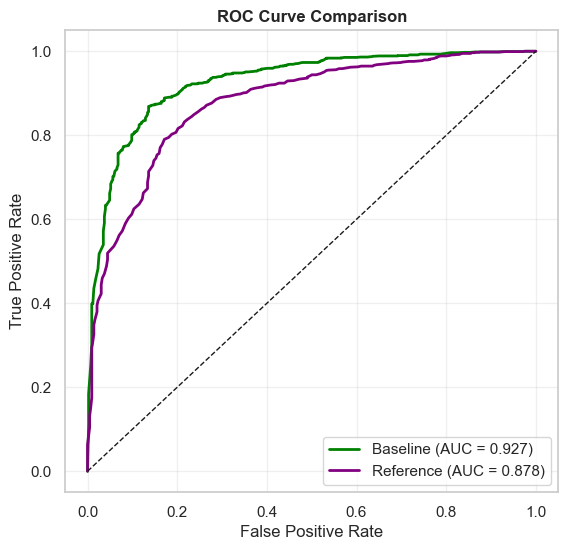

In [71]:
plt.figure(figsize=(14, 6))

# ROC Curves
plt.subplot(1, 2, 1)
# Baseline
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'Baseline (AUC = {auc(fpr_rf, tpr_rf):.3f})')
# Reference
fpr_ref, tpr_ref, _ = roc_curve(y_test, y_prob_ref)
plt.plot(fpr_ref, tpr_ref, color='purple', lw=2, label=f'Reference (AUC = {auc(fpr_ref, tpr_ref):.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

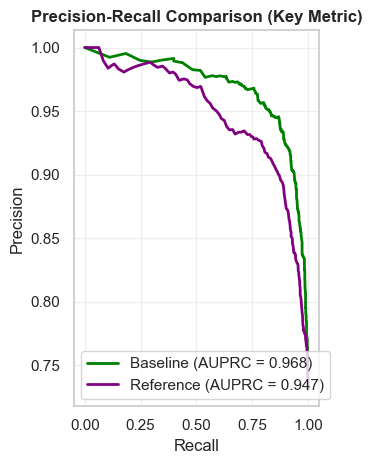

In [72]:
# Precision-Recall Curves
plt.subplot(1, 2, 2)
# Baseline
p_rf, r_rf, _ = precision_recall_curve(y_test, y_prob_rf)
plt.plot(r_rf, p_rf, color='green', lw=2, label=f'Baseline (AUPRC = {auprc_rf:.3f})')
# Reference
p_ref, r_ref, _ = precision_recall_curve(y_test, y_prob_ref)
plt.plot(r_ref, p_ref, color='purple', lw=2, label=f'Reference (AUPRC = {auprc_ref:.3f})')

plt.title('Precision-Recall Comparison (Key Metric)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# The Advanced Architecture

In [74]:
# SETUP DATA (SEQUENCE)/Tokenization
X_train_seq = torch.tensor([fast_tokenize(s) for s in X_train_raw], dtype=torch.long).to(device)
y_train_seq = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)

X_val_seq = torch.tensor([fast_tokenize(s) for s in X_val_raw], dtype=torch.long).to(device)
y_val_seq = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1).to(device)

X_test_seq = torch.tensor([fast_tokenize(s) for s in X_test_raw], dtype=torch.long).to(device)
y_test_seq = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(device)

In [75]:
train_ds = TensorDataset(X_train_seq, y_train_seq)
val_ds = TensorDataset(X_val_seq, y_val_seq)
test_ds = TensorDataset(X_test_seq, y_test_seq)

In [76]:
class HybridCNNLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=64, dropout_rate=0.5):
        super(HybridCNNLSTM, self).__init__()
        
        # Embedding: Transforms integers into dense vectors
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        
        # CNN Block: Extract Local Features
        self.conv1 = nn.Conv1d(embed_dim, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(64) # Helps with faster convergence
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        
        # LSTM Block: Learn sequence dependencies
        self.lstm = nn.LSTM(64, hidden_dim, batch_first=True, bidirectional=True)
        
        # Classification Head
        self.dropout = nn.Dropout(dropout_rate) # avoid Overfit
        self.fc1 = nn.Linear(hidden_dim * 2, 64) 
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # x: [batch, seq_len]
        emb = self.embedding(x).permute(0, 2, 1) # Đổi chiều cho CNN: [batch, embed, seq]
        
        # CNN Flow
        c = self.conv1(emb)
        c = self.bn1(c)
        c = self.relu(c)
        c = self.pool(c) # [batch, 64, seq_len/2]
        
        # LSTM Flow
        l_in = c.permute(0, 2, 1) # [batch, seq, feat]
        out, (hn, _) = self.lstm(l_in)
        
        # get final hidden state (combine both directions)
        final_hidden = torch.cat((hn[-2], hn[-1]), dim=1)
        
        # Fully Connected
        x = self.fc1(final_hidden)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return self.sigmoid(x)

In [77]:
param_grid = {
    'lr': [0.001, 0.0005],
    'hidden_dim': [64, 128],
    'dropout': [0.3, 0.5],
    'batch_size': [32, 64]
}

In [78]:
def train_evaluate(params, epochs=5):
    loader = DataLoader(train_ds, batch_size=params['batch_size'], shuffle=True)
    v_loader = DataLoader(val_ds, batch_size=params['batch_size'])
    
    model = HybridCNNLSTM(vocab_sz, hidden_dim=params['hidden_dim'], dropout_rate=params['dropout']).to(device)
    opt = Adam(model.parameters(), lr=params['lr'])
    crit = nn.BCELoss()
    
    for _ in range(epochs): 
        model.train()
        for Xb, yb in loader:
            opt.zero_grad()
            loss = crit(model(Xb), yb)
            loss.backward()
            opt.step()
            
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for Xb, yb in v_loader:
            val_loss += crit(model(Xb), yb).item()
    return val_loss / len(v_loader)

In [79]:
best_params = None
best_val_loss = float('inf')

for i in range(20):
    current_params = {k: random.choice(v) for k, v in param_grid.items()}
    try:
        loss = train_evaluate(current_params)
        print(f"Trial {i+1}: {current_params} | Val Loss: {loss:.4f}")
        if loss < best_val_loss:
            best_val_loss = loss
            best_params = current_params
            print("  --> New Best!")
    except Exception as e:
        print(f"Trial failed: {e}")

print(f"\nBest Params: {best_params}")

Trial 1: {'lr': 0.001, 'hidden_dim': 64, 'dropout': 0.5, 'batch_size': 32} | Val Loss: 0.4166
  --> New Best!
Trial 2: {'lr': 0.001, 'hidden_dim': 64, 'dropout': 0.3, 'batch_size': 32} | Val Loss: 0.4234
Trial 3: {'lr': 0.0005, 'hidden_dim': 64, 'dropout': 0.3, 'batch_size': 32} | Val Loss: 0.4093
  --> New Best!
Trial 4: {'lr': 0.001, 'hidden_dim': 64, 'dropout': 0.3, 'batch_size': 32} | Val Loss: 0.4220
Trial 5: {'lr': 0.0005, 'hidden_dim': 64, 'dropout': 0.5, 'batch_size': 64} | Val Loss: 0.4268
Trial 6: {'lr': 0.001, 'hidden_dim': 64, 'dropout': 0.5, 'batch_size': 64} | Val Loss: 0.4463
Trial 7: {'lr': 0.0005, 'hidden_dim': 64, 'dropout': 0.3, 'batch_size': 64} | Val Loss: 0.4375
Trial 8: {'lr': 0.001, 'hidden_dim': 64, 'dropout': 0.5, 'batch_size': 32} | Val Loss: 0.4241
Trial 9: {'lr': 0.0005, 'hidden_dim': 128, 'dropout': 0.5, 'batch_size': 32} | Val Loss: 0.4604
Trial 10: {'lr': 0.0005, 'hidden_dim': 64, 'dropout': 0.5, 'batch_size': 32} | Val Loss: 0.4275
Trial 11: {'lr': 0.00

## TRAINING FINAL MODEL

In [80]:
train_loader = DataLoader(train_ds, batch_size=best_params['batch_size'], shuffle=True)
val_loader = DataLoader(val_ds, batch_size=best_params['batch_size'])
test_loader = DataLoader(test_ds, batch_size=best_params['batch_size'])

In [81]:
model = HybridCNNLSTM(vocab_sz, 
                      hidden_dim=best_params['hidden_dim'], 
                      dropout_rate=best_params['dropout']).to(device)
optimizer = Adam(model.parameters(), lr=best_params['lr'])
criterion = nn.BCELoss()

In [89]:
history = {'train_loss': [], 'val_loss': [],'val_f1': [],'val_auprc': []}
best_loss = float('inf')
patience = 8
counter = 0

In [90]:
for epoch in range(50): 
    # --- TRAIN ---
    model.train()
    train_loss = 0
    for Xb, yb in train_loader:
        optimizer.zero_grad()
        out = model(Xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    avg_train_loss = train_loss / len(train_loader)
    
    model.eval()
    val_loss = 0
    y_true_val = []
    y_pred_val = []
    
    with torch.no_grad():
        for Xb, yb in val_loader:
            out = model(Xb)
            loss = criterion(out, yb)
            val_loss += loss.item()
            
            y_true_val.extend(yb.cpu().numpy())
            y_pred_val.extend(out.cpu().numpy())
            
    avg_val_loss = val_loss / len(val_loader)
    
    y_true_val = np.array(y_true_val)
    y_pred_val = np.array(y_pred_val)
    val_f1 = f1_score(y_true_val, (y_pred_val >= 0.5).astype(int))
    val_auprc = average_precision_score(y_true_val, y_pred_val)
    
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['val_f1'].append(val_f1)
    history['val_auprc'].append(val_auprc)
    
    print(f"Epoch {epoch+1:02d} | Loss: {avg_train_loss:.4f} / {avg_val_loss:.4f} | F1: {val_f1:.4f} | AUPRC: {val_auprc:.4f}")
    
    # Early Stopping Check
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        counter = 0
        torch.save(model.state_dict(), f'{model_dir}/best_advanced_model.pth')
        print("Model saved at " + f'{model_dir}')
    else:
        counter += 1
        if counter >= patience:
            print("Early Stopping Triggered!")
            break

Epoch 01 | Loss: 0.3098 / 0.4149 | F1: 0.8783 | AUPRC: 0.9364
Model saved at models
Epoch 02 | Loss: 0.3094 / 0.4384 | F1: 0.8735 | AUPRC: 0.9336
Epoch 03 | Loss: 0.3000 / 0.4200 | F1: 0.8857 | AUPRC: 0.9370
Epoch 04 | Loss: 0.2936 / 0.4185 | F1: 0.8810 | AUPRC: 0.9403
Epoch 05 | Loss: 0.3045 / 0.4270 | F1: 0.8921 | AUPRC: 0.9395
Epoch 06 | Loss: 0.2754 / 0.4232 | F1: 0.8868 | AUPRC: 0.9369
Epoch 07 | Loss: 0.2625 / 0.4502 | F1: 0.8852 | AUPRC: 0.9404
Epoch 08 | Loss: 0.2615 / 0.4446 | F1: 0.8885 | AUPRC: 0.9370
Epoch 09 | Loss: 0.2507 / 0.4351 | F1: 0.8853 | AUPRC: 0.9349
Early Stopping Triggered!


In [91]:
# FINAL EVALUATION
model.load_state_dict(torch.load(f'{model_dir}/best_advanced_model.pth'))
model.eval()
y_prob_dl = []
with torch.no_grad():
    for Xb, _ in test_loader:
        y_prob_dl.extend(model(Xb).cpu().numpy().flatten())

In [92]:
y_prob_dl = np.array(y_prob_dl)
y_pred_dl = (y_prob_dl >= 0.5).astype(int)

In [93]:
auprc_dl = average_precision_score(y_test, y_prob_dl)
f1_dl = f1_score(y_test, y_pred_dl)
print(f"\nAdvanced Model Result: AUPRC={auprc_dl:.4f} | F1={f1_dl:.4f}")


Advanced Model Result: AUPRC=0.9447 | F1=0.8893



Generating Learning Curves...


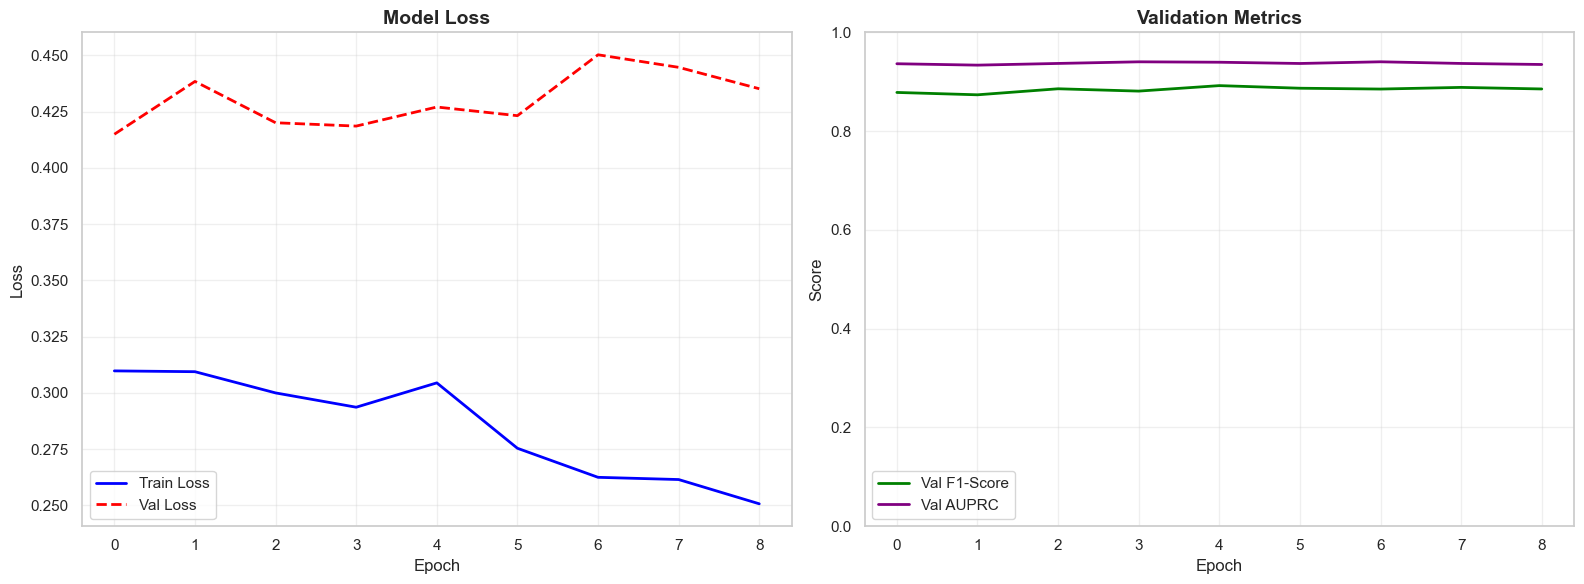

In [ ]:
print("\nGenerating Learning Curves...")
sns.set_theme(style="whitegrid")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Loss
ax1.plot(history['train_loss'], label='Train Loss', color='blue', lw=2)
ax1.plot(history['val_loss'], label='Val Loss', color='red', lw=2, linestyle='--')
ax1.set_title("Model Loss", fontsize=14, weight='bold')
ax1.set_xlabel("Epoch"); ax1.set_ylabel("Loss")
ax1.legend(); ax1.grid(True, alpha=0.3)

#  Metrics
ax2.plot(history['val_f1'], label='Val F1-Score', color='green', lw=2)
ax2.plot(history['val_auprc'], label='Val AUPRC', color='purple', lw=2)
ax2.set_title("Validation Metrics", fontsize=14, weight='bold')
ax2.set_xlabel("Epoch"); ax2.set_ylabel("Score")
ax2.legend(); ax2.grid(True, alpha=0.3)
ax2.set_ylim(0.0, 1.0) 

plt.tight_layout()
plt.show()


# Evaluate 4 models

In [95]:
models_data = [
    {
        'name': 'Random Forest (Baseline)', 
        'prob': y_prob_rf, 
        'pred': y_pred_rf, 
        'color': 'green', 
        'linestyle': '-'
    },
    {
        'name': 'MoLFormer (Reference)',   
        'prob': y_prob_ref, 
        'pred': y_pred_ref, 
        'color': 'purple', 
        'linestyle': '--'
    },
    {
        'name': 'Hybrid CNN-LSTM (Advanced)', 
        'prob': y_prob_dl, 
        'pred': y_pred_dl, 
        'color': 'red', 
        'linestyle': '-'
    },

    {
        'name': 'Simple CNN (Initial)',    
        'prob': y_prob_cnn, 
        'pred': y_pred_cnn, 
        'color': 'blue', 
        'linestyle': ':'
    }
]

results_list = []
for m in models_data:
    auprc = average_precision_score(y_test, m['prob'])
    f1 = f1_score(y_test, m['pred'])
    results_list.append({'Model': m['name'], 'AUPRC': auprc, 'F1-Score': f1})

df_results = pd.DataFrame(results_list).sort_values(by='AUPRC', ascending=False)



In [96]:
print("\nFINAL LEADERBOARD:")
display(df_results)




FINAL LEADERBOARD:


,Model,AUPRC,F1-Score
0,Random Forest (Baseline),0.968133,0.918850
2,Hybrid CNN-LSTM (Advanced),0.944730,0.889269
1,MoLFormer (Reference),0.937632,0.886066
3,Simple CNN (Initial),0.901806,0.863928


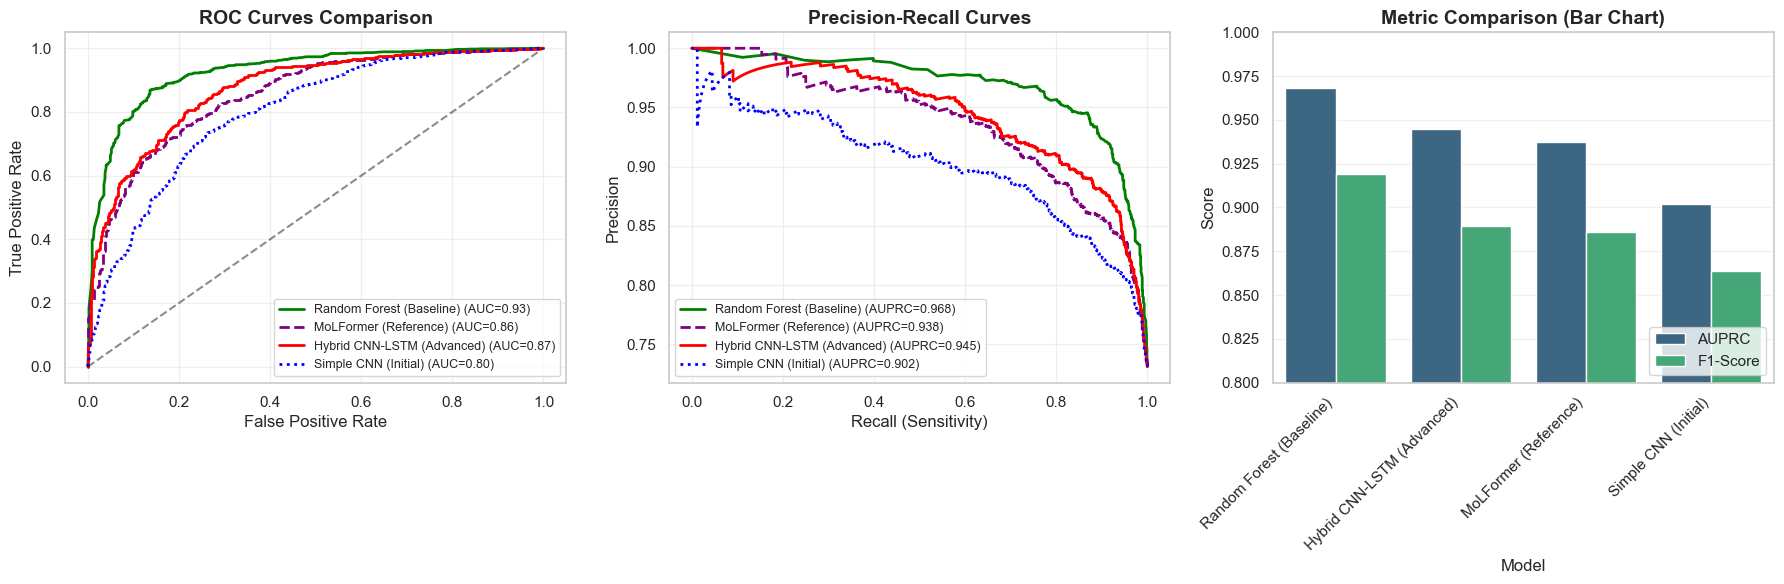

In [97]:
plt.figure(figsize=(18, 6))
sns.set_theme(style="whitegrid")

# ROC CURVES 
plt.subplot(1, 3, 1)
for m in models_data:
    fpr, tpr, _ = roc_curve(y_test, m['prob'])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=m['color'], linestyle=m['linestyle'], lw=2, 
             label=f"{m['name']} (AUC={roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.title("ROC Curves Comparison", fontsize=14, weight='bold')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right", fontsize=9)
plt.grid(True, alpha=0.3)

#  PRECISION-RECALL CURVES
plt.subplot(1, 3, 2)
for m in models_data:
    p, r, _ = precision_recall_curve(y_test, m['prob'])
    ap = average_precision_score(y_test, m['prob'])
    plt.plot(r, p, color=m['color'], linestyle=m['linestyle'], lw=2, 
             label=f"{m['name']} (AUPRC={ap:.3f})")

plt.title("Precision-Recall Curves", fontsize=14, weight='bold')
plt.xlabel("Recall (Sensitivity)")
plt.ylabel("Precision")
plt.legend(loc="lower left", fontsize=9)
plt.grid(True, alpha=0.3)

#  BAR CHART COMPARISON
plt.subplot(1, 3, 3)
df_melted = df_results.melt(id_vars="Model", var_name="Metric", value_name="Score")
sns.barplot(data=df_melted, x='Model', y='Score', hue='Metric', palette='viridis')
plt.title("Metric Comparison (Bar Chart)", fontsize=14, weight='bold')
plt.ylim(0.8, 1.0)
plt.xticks(rotation=45, ha='right')
plt.legend(loc='lower right')
plt.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()